##Transfer Leraning-Feature Extraction

Trafnsfer leraning is using existing working model to our problrm

1.can leverage exusting neural network architecture to work

2.can use already leraned patterns to our network

In [1]:
#check the gpu
!nvidia-smi

Fri Jul 16 04:32:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Download and Import data

In [2]:
#download the dataset
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip data file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip","r")

zip_ref.extractall()
zip_ref.close()

--2021-07-16 04:32:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   244MB/s    in 0.7s    

2021-07-16 04:32:33 (244 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
#spect data
import os

#wak though data
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directoories and {len(filenames)} images in '{dirpath}'")


There are 2 directoories and 0 images in '10_food_classes_10_percent'
There are 10 directoories and 0 images in '10_food_classes_10_percent/test'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directoories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directoories and 250 images in '10_food_classes_10_percen

##Prepare data

imagedatageneator to load data into batches

In [4]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir ="10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

# class FixedImageDataGenerator(ImageDataGenerator):
#     def standardize(self, x):
#         if self.featurewise_center:
#             x = ((x/255.) - 0.5) * 2.
#         return x

train_datagen =ImageDataGenerator(rescale=1/255.,featurewise_center=True)
test_datagen =ImageDataGenerator(rescale=1/255.,featurewise_center=True)

print("Training Images")
train_data_10_percent =train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")


print("Test Images")
test_data =test_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")



Training Images
Found 750 images belonging to 10 classes.
Test Images
Found 2500 images belonging to 10 classes.


##Set Callbacks

1.tracking experiments with callbacks

2.model check pointing

3.stoping the model stop overfitting by early stopping callbacks

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##Craeting models using Tensorflow HUB

link :https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


resent model :https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5



In [6]:
#compare two model
resnet_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficinet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
#create_model fucntion 
def create_model(model_url,num_classes=10):
  """
  Takes tensorflow hub url and create sequnetial model with it

  Args:
   model_url =Tensorflow hub model url
   num_clasese=Number of outputs

  returns:
    an uncomplied model with model_url as feature extraction
  """

  #download the pre trainded model
  feature_extractor_layer =hub.KerasLayer(model_url,
                                          trainable =False,
                                          name="feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE+(3,))
  
  #create the model
  model=tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model




##Create Resnet Feature Extaction Model

link :https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb#scrollTo=2GTl0fwE0Hx6


In [9]:
#create Resnet Model
resnet_model =create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
#compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
#fit the model
history_resnet_model =resnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name ="resnet_v2_50"
                                                              )])

Saving TensorBoard log files to: tensorflow_hub/resnet_v2_50/20210716-043239
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


24/24 [==============================] - 32s 1s/step - loss: 2.0403 - accuracy: 0.3200 - val_loss: 1.3130 - val_accuracy: 0.5880
Epoch 2/5
24/24 [==============================] - 16s 681ms/step - loss: 0.9479 - accuracy: 0.7200 - val_loss: 0.9273 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.6401 - accuracy: 0.8253 - val_loss: 0.7989 - val_accuracy: 0.7408
Epoch 4/5
24/24 [==============================] - 15s 655ms/step - loss: 0.4980 - accuracy: 0.8613 - val_loss: 0.7790 - val_accuracy: 0.7360
Epoch 5/5
24/24 [==============================] - 16s 689ms/step - loss: 0.4058 - accuracy: 0.8867 - val_loss: 0.7193 - val_accuracy: 0.7668


In [13]:
#evalaute the model
resnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


79/79 [==============================] - 13s 159ms/step - loss: 0.7193 - accuracy: 0.7668


[0.7193498015403748, 0.7667999863624573]

##Plot loss Curves

In [14]:
import matplotlib.pyplot as plt


#plot the validation and training curve
def plot_loss_curve(history):
  """
  Returns separte loss curve for trainnnig and validation mtrics
  """

  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot Accuracy
  plt.figure()
  plt.plot(epochs,loss,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



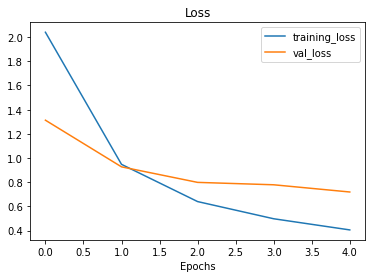

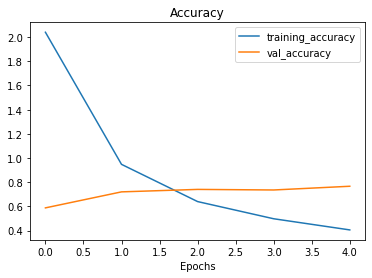

In [15]:
plot_loss_curve(history_resnet_model)

##Create Efficientnet Feature Extaction Model

In [16]:
#create Resnet Model
efficientnet_model =create_model(efficinet_url,
                           num_classes=train_data_10_percent.num_classes)

#compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

#fit the model
history_efficient_model =efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name ="efficientnet_model"
                                                              )])


Saving TensorBoard log files to: tensorflow_hub/efficientnet_model/20210716-043436
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


24/24 [==============================] - 27s 841ms/step - loss: 1.8758 - accuracy: 0.4387 - val_loss: 1.3138 - val_accuracy: 0.7216
Epoch 2/5
24/24 [==============================] - 15s 632ms/step - loss: 1.0847 - accuracy: 0.7760 - val_loss: 0.8716 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 15s 630ms/step - loss: 0.7637 - accuracy: 0.8453 - val_loss: 0.7004 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 15s 646ms/step - loss: 0.6147 - accuracy: 0.8613 - val_loss: 0.6142 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.5219 - accuracy: 0.8787 - val_loss: 0.5634 - val_accuracy: 0.8592


In [20]:
#evalaute the model
efficientnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


79/79 [==============================] - 12s 152ms/step - loss: 0.5634 - accuracy: 0.8592


[0.5633593201637268, 0.8592000007629395]

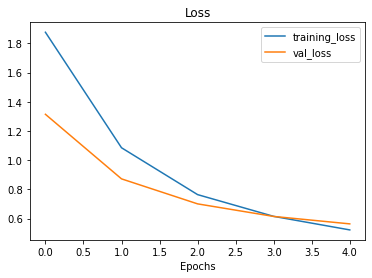

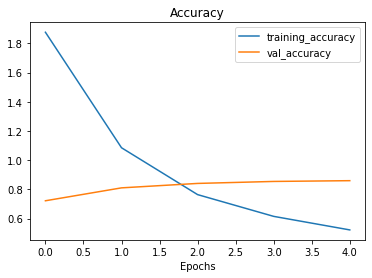

In [18]:
plot_loss_curve(history_efficient_model)

##Different Types of Transfer Learning

1.using the model as above 

2.feature extraction tranfer learning and adjust the output layer for your problem

3.Fine tuning the transfer learning.

##Compare Model Results with TensorBoard

In [ ]:
# # upload tensorboard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#  --name "Effcientnet B0 vs ResNet 50 v2" \
#  --description "comapring two models with same dataset" \
#  --one_shot

##New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/fpMlzd10S82MBjqOGOjyqQ/

In [24]:
#check out the experiments
!tensorboard dev list

2021-07-16 04:53:58.123898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/fpMlzd10S82MBjqOGOjyqQ/
	Name                 Effcientnet B0 vs ResNet 50 v2
	Description          comapring two models with same dataset
	Id                   fpMlzd10S82MBjqOGOjyqQ
	Created              2021-07-16 04:47:40 (6 minutes ago)
	Updated              2021-07-16 04:47:49 (6 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              240
	Tensor bytes         0
	Binary object bytes  19426158
Total: 1 experiment(s)


In [ ]:
# #delete experiment
# !tensorboard dev delete --experiment_id xxxxxxxxxxxxxx